In [ ]:
%%capture
%load_ext autoreload
%autoreload 2
%reset -f

In [ ]:
from collections import abc

import numpy as np
from matplotlib import pyplot as plt

from harmonic_balance import arclength_continuation as alc
from harmonic_balance import freq

ndarray = np.ndarray

## Define nonlinear force

In [ ]:
def get_slice(dof: int, N: int):
    return np.s_[dof * N : (dof + 1) * N]


def get_nonlinear(
    factor: float,
) -> tuple[
    abc.Callable[[ndarray, ndarray, int], ndarray],
    abc.Callable[[ndarray, ndarray, int], ndarray],
    abc.Callable[[ndarray, ndarray, int], ndarray],
]:
    dof = 0
    s_ = lambda N: get_slice(dof, N)

    def f_nl(x: ndarray, xdot: ndarray, N: int) -> ndarray:
        res = np.zeros_like(x, dtype=float)
        res[s_(N)] += factor * x[s_(N)] ** 3
        return res

    def df_nl_dx(x: ndarray, xdot: ndarray, N: int) -> ndarray:
        res = np.zeros_like(x, dtype=float)
        res[s_(N)] += factor * 3 * x[s_(N)] ** 2
        return np.diag(res)

    def df_nl_d_xdot(x: ndarray, xdot: ndarray, N: int) -> ndarray:
        shape = x.shape[0]
        return np.zeros((shape, shape), dtype=float)

    return f_nl, df_nl_dx, df_nl_d_xdot

## Define system

In [ ]:
alpha = 2
beta = 4
delta = 1
gamma = 10

omega = 2
n = 1

m1 = 1
c1 = delta
k1 = alpha

M = np.array([[m1]])
C = np.array([[c1]])
K = np.array([[k1]])

ks = (1,)
dofs = (0,)
is_cosines = (1,)
coefficients = (gamma,)

factor = beta
f_nl, df_nl_dx, df_nl_d_xdot = get_nonlinear(factor)

## Set harmonic balance parameters

In [ ]:
NH = 30
N = 256

b_ext = freq.get_b_ext(NH, n, ks, dofs, is_cosines, coefficients)

## Compute NLFR curve

In [ ]:
omega_i0 = 3.5

num_points = 100
s = 0.02
tol = 1e-5
max_iter = 100

ys0, rel_errors0, convergeds0, iters0 = alc.compute_nlfr_curve(
    num_points,
    omega_i0,
    b_ext,
    f_nl,
    df_nl_dx,
    df_nl_d_xdot,
    NH,
    n,
    N,
    s,
    M,
    C,
    K,
    tol,
    max_iter,
)

In [ ]:
omega_i0 = 3.65

num_points = 300

ys1, rel_errors1, convergeds1, iters1 = alc.compute_nlfr_curve(
    num_points,
    omega_i0,
    b_ext,
    f_nl,
    df_nl_dx,
    df_nl_d_xdot,
    NH,
    n,
    N,
    s,
    M,
    C,
    K,
    tol,
    max_iter,
)

iteration 254 didn't converge
iteration 255 didn't converge
iteration 256 didn't converge
iteration 257 didn't converge
iteration 258 didn't converge
iteration 259 didn't converge
iteration 260 didn't converge
iteration 261 didn't converge
iteration 262 didn't converge
iteration 263 didn't converge
iteration 264 didn't converge
iteration 265 didn't converge
iteration 266 didn't converge
iteration 267 didn't converge
iteration 268 didn't converge
iteration 269 didn't converge
iteration 270 didn't converge
iteration 271 didn't converge
iteration 272 didn't converge
iteration 273 didn't converge
iteration 274 didn't converge
iteration 275 didn't converge
iteration 276 didn't converge
iteration 277 didn't converge
iteration 278 didn't converge
iteration 279 didn't converge
iteration 280 didn't converge
iteration 281 didn't converge
iteration 282 didn't converge
iteration 283 didn't converge
iteration 284 didn't converge
iteration 285 didn't converge
iteration 286 didn't converge
iteration 

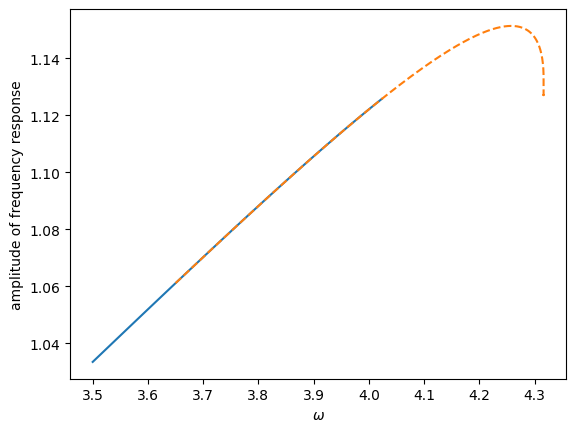

In [ ]:
is_inf = np.any(np.isinf(ys0), axis=1) | (ys0[:, -1] > 1e2)
amplitudes0 = np.linalg.norm(ys0[~is_inf][:, :-1], axis=1)
omegas0 = ys0[~is_inf][:, -1].real

if "ys1" in locals():
    amplitudes1 = np.linalg.norm(ys1[:, :-1], axis=1)
    omegas1 = ys1[:, -1].real

fig, ax = plt.subplots(1, 1)

s_ = np.s_[:]
ax.plot(omegas0[s_], amplitudes0[s_])

if "ys1" in locals():
    s_ = np.s_[:]
    ax.plot(omegas1[s_], amplitudes1[s_], ls="--")

ax.set_xlabel("$\omega$")
ax.set_ylabel("amplitude of frequency response")

plt.show()